<a href="https://colab.research.google.com/github/ediminished/Deep-Learning/blob/main/GoogLe_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import tqdm

## Model
```https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf```

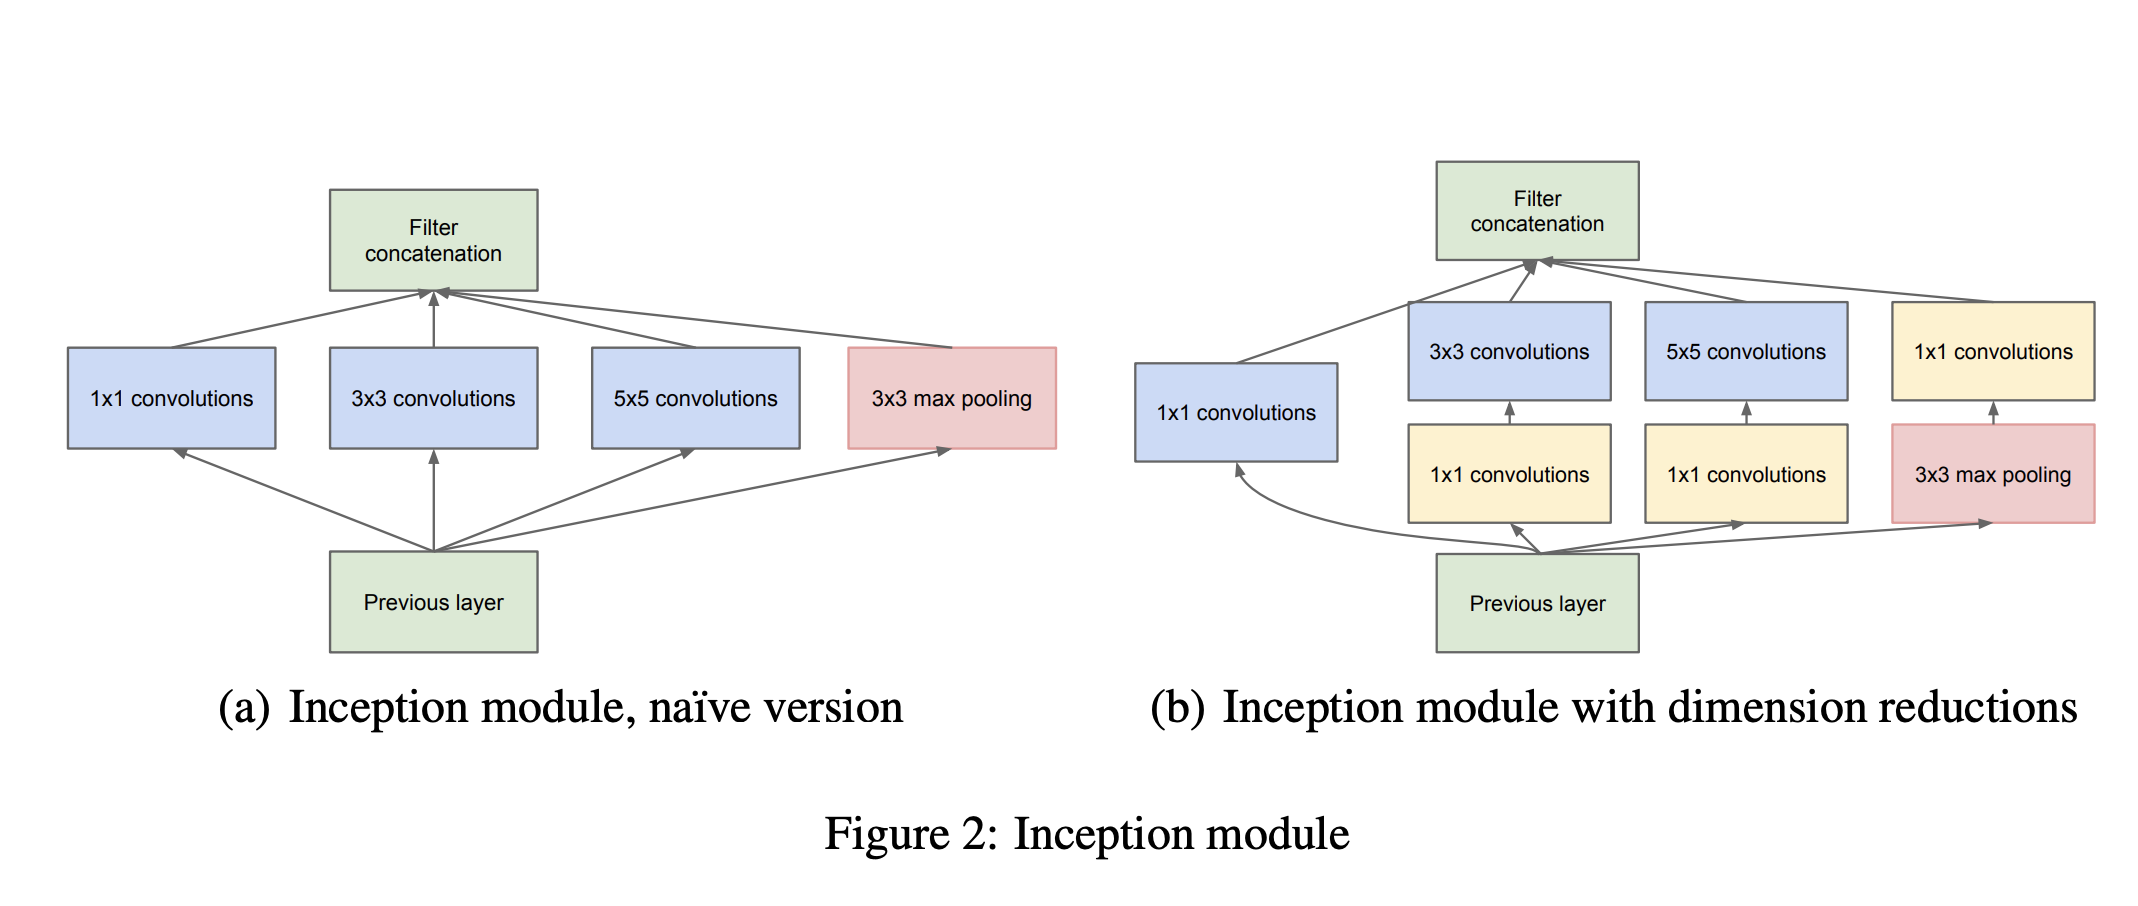

In [20]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs) 
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    x = self.batchnorm(x) 
    x = self.relu(x)
    return x

torch.Size([64, 16, 110, 110])

In [21]:
class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, reduction_3x3, out_3x3, reduction_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
    self.branch2 = nn.Sequential(
        conv_block(in_channels, reduction_3x3, kernel_size=1),
        conv_block(reduction_3x3, out_3x3, kernel_size=3, padding=1)
    )
    self.branch3 = nn.Sequential(
        conv_block(in_channels, reduction_5x5, kernel_size=1),
        conv_block(reduction_5x5, out_5x5, kernel_size=5, padding=2)
    )
    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        conv_block(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self, x):
    # (N, kernel_size, width, height)
    # print(self.branch1(x).shape, self.branch2(x).shape, self.branch3(x).shape, self.branch4(x).shape)
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

In [26]:
class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.7)
    self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.conv = conv_block(in_channels, 128, kernel_size=1)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [27]:
# Input batch (N, channels, 224, 224), so reshape your inputs accordingly
class GoogLeNet(nn.Module):
  def __init__(self, in_channels=3, aux_logits=True, num_classes=1000):
    super(GoogLeNet, self).__init__()
    self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(in_channels=64, out_channels=192, kernel_size=(3,3), stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)
    
    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout2d(p=0.4)
    self.fc1 = nn.Linear(in_features=1024, out_features=1000)
  
  def forward(self, x):
    x = self.conv1(x) 
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x) 

    x = self.inception3a(x) 
    x = self.inception3b(x) 
    x = self.maxpool3(x) 

    x = self.inception4a(x) 
    x = self.inception4b(x) 
    x = self.inception4c(x) 
    x = self.inception4d(x) 
    x = self.inception4e(x) 
    x = self.maxpool4(x) 

    x = self.inception5a(x) 
    x = self.inception5b(x) 
    
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x) 
    x = self.fc1(x)
    return x

In [28]:
x = torch.randn(64, 3, 224, 224)

block = conv_block(3, 16, kernel_size=(5, 5), stride=2)
block(x).shape

torch.Size([64, 16, 110, 110])

In [29]:
x = torch.randn(64, 3, 224, 224)

block = Inception_block(3, 10, 20, 30, 40, 50, 60)
block(x).shape

torch.Size([64, 150, 224, 224])

In [30]:
x = torch.randn(64, 3, 224, 224)

block = GoogLeNet()
block(x).shape

torch.Size([64, 1000])